# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.5 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import pandas as pd
import random
import torch
from collections import deque

# TODO Delete unneccesary imports
#from config import Config
#from normalizer import MeanStdNormalizer
#from ppo_agent import PPOAgent
#from network import GaussianActorCriticNet, FCBody
import ddpg_agent
from helper import *
from workspace_utils import active_session

%matplotlib inline

RANDOM_SEED = 42

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to the environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Scores over this episode: {:.3f} {:.3f}'.format(scores[0], scores[1]))

Scores over this episode: 0.000 -0.010
Scores over this episode: -0.010 0.100
Scores over this episode: 0.000 -0.010
Scores over this episode: 0.000 -0.010
Scores over this episode: 0.000 -0.010


When finished, you can close the environment.

In [6]:
# env.close()

### helper.py

In [7]:
# Modified from Navigation

def run_steps(max_episodes=1000, max_steps=1e5, scores_window_len=100, target_score = 0.5, 
               print_interval = 10, save_interval=10, resume_training=False, load_checkpoint_path = 'checkpoint.tar'):
    """Deep Q-Learning.
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        scores_window_len: a rolling window size for averaging the scores
        goal_score: the minimum average score required for a satisfactory model
        print_every: how often to print an average score for that interval 
            (average score is not for scores_window_len!)
        save_every: interval for saving the model weights, optimizers, and memory
        resume_training: whether or not to start training from a saved checkpoint
        path: filename for loading and saving the checkpoint
    """
    agents = ddpg_agent.Agent(state_size, action_size, num_agents, RANDOM_SEED)  # create agents
              
    scores_per_episode = []                                     # List containing agent scores from each episode
    steps_per_episode = []
    max_scores_window = deque(maxlen=scores_window_len)  # last however many scores
    steps_window = deque(maxlen=scores_window_len)
    toc = time.time()
    
    # Load a checkpoint
    if resume_training:
        agents, scores_per_episode, steps_per_episode = \
        load_checkpoint(agents, scores_per_episode,
                        steps_per_episode, load_checkpoint_path)
        for score in scores_per_episode:
            max_scores_window.append(score.max())
        for step in steps_per_episode:
            steps_window.append(step)
    
    for episode in range(len(scores_per_episode)+1, max_episodes+1):
        # Run an episode
        env_info = env.reset(train_mode=True)[brain_name]    # reset the environment
        states = env_info.vector_observations                # get the current states
        scores = np.zeros(num_agents)                        # initialize the score (for each agent)
        agents.reset()                                       # reset internal noise state to mu
        for step in range(1, max_steps+1):          
            actions = agents.act(states)                     # agents act
            env_info = env.step(actions)[brain_name]         # step the environment
            next_states = env_info.vector_observations       # observe next state
            rewards = env_info.rewards                       # observe rewards
            dones = env_info.local_done                      # observe dones             
                                                             # save the experience and learn
            agents.step(states, actions, rewards, next_states, dones)
            states = next_states                             # roll over states to next time step
            scores += rewards                                # update the score (for each agent)
                                                             # display time steps and mean of all agent scores
            if np.any(dones):                                # exit loop if episode finished
                break    
        
        # Record scores from the episode
        scores_per_episode.append(scores)
        max_scores_window.append(scores.max())
        steps_per_episode.append(step)
        steps_window.append(step)
        
        # Print out scores after each episode and every print interval
        tic = time.time()
        s = '\rEpisode: {}\tScores: {:.3f} {:.3f}\tSteps: {}\tTime Elapsed: {:.1f} min'
        print(s.format(episode, scores[0], scores[1], step, (tic-toc)/60), end=" ")
        
        if episode % print_interval == 0:                
            s = '\rEpisode: {}\tAverage Max Score: {:.3f}\tAverage steps: {:.1f}\tSize of memory: {}'
            print(s.format(episode, np.mean(max_scores_window), 
                           np.mean(steps_window), len(agents.memory)),  end=" "*35+"\n")
        
        if episode % save_interval == 0:
            path = f'checkpoint-{episode}.tar'
            save_checkpoint(agents, scores_per_episode, steps_per_episode, ddpg_agent, path)
        
        if (np.mean(max_scores_window) >= target_score and 
            episode >= scores_window_len):
            print('\nEnvironment solved in {} episodes!!!'.format(episode))
            print('Average score over {} episodes was: {:.3f}'
                  .format(scores_window_len, np.mean(max_scores_window)))
            print('Time Elapsed: {:.1f} min'.format((tic-toc)/60))
            path = f'checkpoint-{episode}.tar'
            save_checkpoint(agents, scores_per_episode, steps_per_episode, ddpg_agent, path)
            break
        
    print('Time Elapsed: {:.1f} min'.format((tic-toc)/60))
    
    return scores_per_episode, steps_per_episode

In [11]:
with active_session():
    scores, steps = run_steps(max_episodes=20, max_steps=10000, scores_window_len=100, target_score = 0.5, 
                              print_interval=10, save_interval=10,
                              resume_training=False, load_checkpoint_path=f'checkpoint-{10}.tar')

Episode: 10	Average Max Score: 0.009	Average steps: 15.8	Size of memory: 316                                   
Episode: 20	Average Max Score: 0.005	Average steps: 15.0	Size of memory: 600                                   
Time Elapsed: 0.1 min


# `Set Config and Run All above`

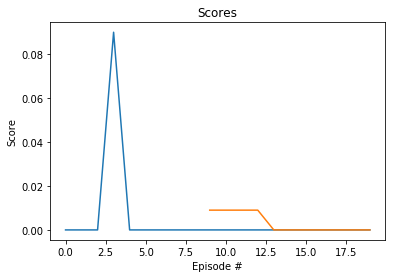

In [12]:
plot_scores([max(score) for score in scores], rolling_window=10, title = 'Scores')

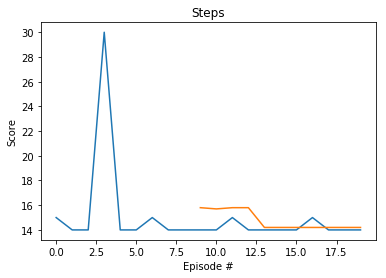

In [13]:
plot_scores(steps, rolling_window=10, title = 'Steps')

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 